<a href="https://colab.research.google.com/github/natskiu/Nasa-Battery/blob/main/Data_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data and feature extraction

In this notebook, we import and process the raw experimental data to extract the required features. We then store these into a Pandas dataframe which can be exported to a csv file for future use.

## Importing libraries and loading data

In [145]:
import numpy as np
import matplotlib.pyplot as plt
#this is a comment
import scipy.io as sio
import pandas as pd
import modules.utils as tools


In [146]:
import importlib
tools = importlib.reload(tools)

In [125]:
# raw=true is important so you download the file rather than the webpage.
#!wget https://github.com/natskiu/Nasa-Battery/blob/main/Data/B0005.mat?raw=true
# rename the file - we are importing the data for one battery, B0005.
#!mv B0005.mat\?raw\=true B0005.mat
# update scipy
#!pip install -U -q scipy
# Load the data
from scipy import io
import os
datapath = 'Data/'
v = io.loadmat(datapath + 'B0053.mat')

## Preprocessing raw data

### Raw data structure 
The raw battery data (defined as v) is a nested dictionary with keys = ['__header__', '__version__', '__globals__', 'B0005']

In [43]:
v.keys()

dict_keys(['__header__', '__version__', '__globals__', 'B0006'])

In [127]:
# This extracts the data for all cycles in the form of a nested numpy array.
raw_cycles = np.vstack(v['B0053'][0,0])
type(raw_cycles)

numpy.ndarray

In [128]:
raw_cycles.shape

(1, 137)

In [129]:
# the middle index indicates the charge/discharge number. 
# For example, cycles[0,0][3] gets the data for the first charge, cycles[0,1][3] gets the data for the first discharge, etc.
raw_cycles[0,0][3].shape

(1, 1)

In [133]:
discharge_indices = tools.get_indices(raw_cycles, is_charge = False)
discharge_indices = discharge_indices[1:]
print(discharge_indices)
len(discharge_indices)

[4, 6, 8, 10, 12, 16, 18, 20, 22, 24, 28, 30, 32, 34, 36, 40, 42, 44, 46, 48, 52, 56, 58, 60, 62, 64, 68, 70, 72, 74, 76, 80, 82, 84, 86, 88, 92, 94, 96, 98, 100, 104, 108, 110, 112, 114, 116, 120, 122, 124, 126, 128, 132, 134, 136]


55

In [134]:
charge_indices = tools.get_indices(raw_cycles, is_charge=True)
# manually look through the repeated charge cycle
#charge_indices.remove(114)
#charge_indices.remove(137)
print(charge_indices)
len(charge_indices)

[2, 5, 7, 9, 11, 14, 17, 19, 21, 23, 26, 29, 31, 33, 35, 38, 41, 43, 45, 47, 50, 54, 57, 59, 61, 63, 66, 69, 71, 73, 75, 78, 81, 83, 85, 87, 90, 93, 95, 97, 99, 102, 106, 109, 111, 113, 115, 118, 121, 123, 125, 127, 130, 133, 135]


55

In [9]:
"This is how you extract all the features from cycles"
#np.vstack(cycles[0,0][3][0,0])[0]

'This is how you extract all the features from cycles'

In [135]:
new_cycles = tools.capacity_vectorizer(discharge_indices, raw_cycles)

In [136]:
new_cycles.shape

(1, 137)

In [140]:
new_cycles[0,4][3][0,0][6].shape

(233,)

## Functions to extract features from original dataset

### Features
#### Discharging cycle

1. Time taken for discharging temperature to reach max value (set threshold ~ 1000s)
2. Max. temperature during discharge
3. Slope for temperature during discharge 
(max_temp - initial_temp)/(time_at_max_temp)
4. Time for voltage_measured to drop below 3 Volts
5. Slope for first 20 data points of voltage_measured

#### Charging cycle

6. Time  taken for charging temperature to reach max value (set threshold ~ 1000s)
7. Max. temperature during charge

### Label
* Capacity recorded for each discharging cycle


## Data Exploration

In [153]:
feature_1_list, feature_2_list = tools.extract_feature_1_2_6_7(discharge_indices, new_cycles, threshold=0)
feature_6_list, feature_7_list = tools.extract_feature_1_2_6_7(charge_indices, new_cycles)
feature_3_list = tools.extract_feature_3(discharge_indices, new_cycles, threshold=0)
feature_4_list = tools.extract_feature_4(new_cycles, discharge_indices, voltage_cutoff=4, threshold=1)
feature_5_list = tools.extract_feature_5(new_cycles, discharge_indices, start_time=1, end_time=20)
label_list = tools.extract_label(new_cycles, discharge_indices)
remaining_cycles_list = tools.remaining_cycles(new_cycles, discharge_indices, threshold=0.7)

In [154]:
print(remaining_cycles_list)

[53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, -1]


In [95]:
tools.cycle_plotter(new_cycles,[])

In [155]:
features_dict = {'time_for_max_temp_D':feature_1_list,'max_temp_D':feature_2_list,
                 'slope_temp_D': feature_3_list, 'time_voltage_measured_below3_D':feature_4_list,
                 'slope_voltage_measured_D':feature_5_list, 'time_for_max_temp_C':feature_6_list,
                 'max_temp_C':feature_7_list, 'capacity': label_list, 'remaining_cycles': remaining_cycles_list}

In [156]:
df = pd.DataFrame(data = features_dict)
df

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity,remaining_cycles
0,2560.688,18.304754,0.004983,21.204,-0.018511,2102.016,8.673290,1.154073,53
1,2522.375,19.339428,0.005227,21.156,-0.018336,1005.985,9.278409,1.150153,52
2,2488.719,18.729143,0.005156,21.281,-0.018318,1008.718,9.444375,1.130586,51
3,2474.844,18.709412,0.005152,21.281,-0.018320,1068.641,9.394873,1.121790,50
4,2255.234,18.635706,0.005671,21.344,-0.018338,1014.969,9.405621,1.113598,49
5,2495.500,21.292306,0.006565,21.282,-0.018488,2016.016,8.589623,1.086465,48
6,2481.078,21.011600,0.006700,21.359,-0.018166,1039.282,9.070302,1.064749,47
7,2460.125,20.939939,0.005845,21.437,-0.018003,1720.875,8.907676,1.080929,46
8,2277.390,19.283837,0.005866,21.500,-0.018212,2249.125,8.597463,1.085275,45
9,2449.922,21.101392,0.006781,21.562,-0.018030,1023.360,9.293888,1.050480,44


In [119]:
filepath = 'processed_csv/'
name = 'B0018_processed.csv'
df.to_csv(filepath+name)

In [37]:
df.describe()

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity,remaining_cycles
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,2846.875994,39.845110,0.005613,2754.208619,-0.000397,2658.187280,29.456190,1.572502,76.500000
std,342.720870,1.118020,0.001053,362.104457,0.000046,556.328245,0.692348,0.190413,48.641546
min,2327.750000,37.801336,0.004146,2222.094000,-0.000474,1004.344000,23.888926,1.287453,-7.000000
25%,2520.270000,38.804674,0.004540,2408.808500,-0.000439,2174.832000,29.200590,1.390021,34.750000
50%,2818.523500,40.080753,0.005652,2713.586000,-0.000397,2588.718500,29.465142,1.557085,76.500000
75%,3195.621250,40.865238,0.006538,3132.226750,-0.000348,3203.429000,29.827732,1.769163,118.250000
max,3366.781000,41.450232,0.007380,3290.750000,-0.000332,3494.703000,31.187718,1.856487,160.000000


In [29]:
discharge_indices[30]

85

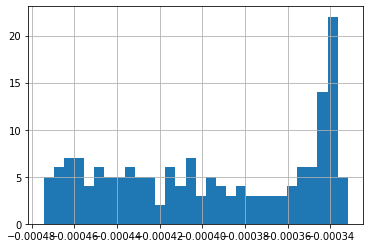

In [30]:
df['slope_voltage_measured_D'].hist(bins=30)

In [61]:
corr_matrix = df.corr()
corr_matrix

,time_for_max_temp_D,max_temp_D,slope_temp_D,time_voltage_measured_below3_D,slope_voltage_measured_D,time_for_max_temp_C,max_temp_C,capacity,remaining_cycles
time_for_max_temp_D,1.000000,-0.851005,-0.981657,0.999841,0.967714,0.899845,-0.256983,0.999871,0.981540
max_temp_D,-0.851005,1.000000,0.890961,-0.852979,-0.846441,-0.806442,0.479673,-0.850417,-0.838338
slope_temp_D,-0.981657,0.890961,1.000000,-0.982063,-0.985759,-0.900880,0.257822,-0.981949,-0.978361
time_voltage_measured_below3_D,0.999841,-0.852979,-0.982063,1.000000,0.967194,0.900654,-0.259000,0.999847,0.980568
slope_voltage_measured_D,0.967714,-0.846441,-0.985759,0.967194,1.000000,0.892016,-0.207489,0.968128,0.988475
time_for_max_temp_C,0.899845,-0.806442,-0.900880,0.900654,0.892016,1.000000,-0.025735,0.898956,0.900037
max_temp_C,-0.256983,0.479673,0.257822,-0.259000,-0.207489,-0.025735,1.000000,-0.257526,-0.224656
capacity,0.999871,-0.850417,-0.981949,0.999847,0.968128,0.898956,-0.257526,1.000000,0.981681
remaining_cycles,0.981540,-0.838338,-0.978361,0.980568,0.988475,0.900037,-0.224656,0.981681,1.000000


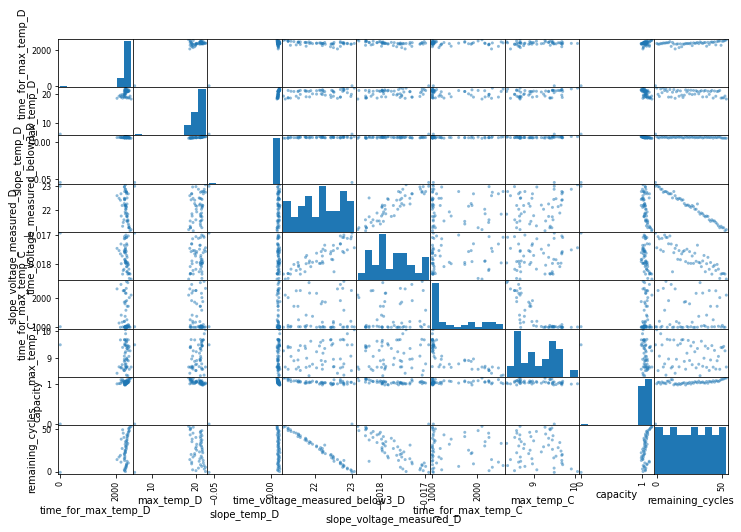

In [157]:
from pandas.plotting import scatter_matrix

attributes = df.columns
scatter_matrix(df[attributes], figsize=(12,8))
plt.show()

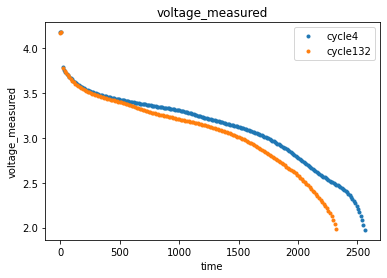

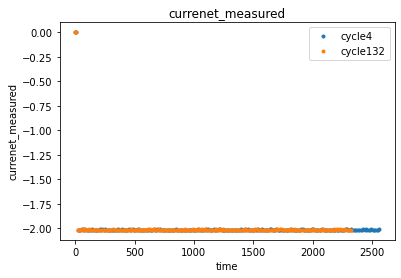

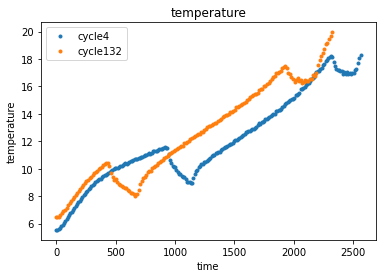

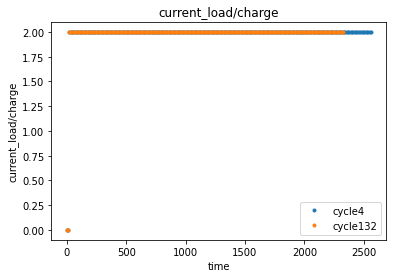

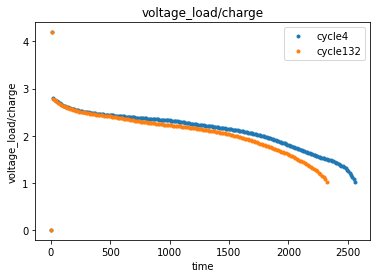

In [159]:
tools.cycle_plotter(new_cycles, [4,132])